In [45]:
# Include so results on different machines are (should be) the same.
import numpy as np
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

import random as rn
rn.seed(3)

In [4]:
!jupyter nbconvert --to script Keras_Character_SimpleRNN.ipynb

[NbConvertApp] Converting notebook Keras_Character_SimpleRNN.ipynb to script
[NbConvertApp] Writing 16973 bytes to Keras_Character_SimpleRNN.py


In [46]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup

load_verbose = 0
loaded_labels = []
loaded_text = []
presidents = [
    "Barack Obama",
    "Donald J. Trump",
    "Dwight D. Eisenhower",
    "Franklin D. Roosevelt",
    "George Bush",
    "George W. Bush",
    "Gerald R. Ford",
    "Harry S. Truman",
    "Herbert Hoover",
    "Jimmy Carter",
    "John F. Kennedy",
    "Lyndon B. Johnson",
    "Richard Nixon",
    "Ronald Reagan",
    "William J. Clinton"
]

labels = {}
for idx, name in enumerate(presidents):
    labels[name] = idx

# load raw text files straight in, no parsing
file_to_label = {
    "Obama": "Barack Obama",
    "Trump": "Donald J. Trump",
    "Eisenhower": "Dwight D. Eisenhower",
    "Roosevelt": "Franklin D. Roosevelt",
    "Bush": "George Bush",
    "WBush": "George W. Bush",
    "Ford": "Gerald R. Ford",
    "Truman": "Harry S. Truman",
    "Hoover": "Herbert Hoover",
    "Carter": "Jimmy Carter",
    "Kennedy": "John F. Kennedy",
    "Johnson": "Lyndon B. Johnson",
    "Nixon": "Richard Nixon",
    "Reagan": "Ronald Reagan",
    "Clinton": "William J. Clinton"
}

directory = "../data/processed/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 


print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."
# processed2 now contains files generated from unprocessed
directory = "../data/processed3/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 

print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."

Loaded 47 speeches for 14 presidents.
Loaded 1764 speeches for 15 presidents.


In [47]:
#
# Bagnall 2015 text pre-processing
#
from string import maketrans
import re

chars_to_replace = "[]%!()>=*&_}+"
sub_chars = len(chars_to_replace) * " "
trantab = maketrans(chars_to_replace, sub_chars)
for x in range(0,len(loaded_text)):
    # "Various rare characters that seemed largely equivalent are mapped together..."
    loaded_text[x] = re.sub('`', '\'', loaded_text[x])
    loaded_text[x] = re.sub('--', '-', loaded_text[x])
    loaded_text[x] = re.sub('\n\n', '\n', loaded_text[x])
    # "...all digits in all languages are mapped to 7"
    loaded_text[x] = re.sub('[0-9]+', '7', loaded_text[x])
    # "...any character with a frequency lower than 1 in 10,000 is discarded."
    loaded_text[x] = loaded_text[x].translate(trantab)
    # "Runs of whitespace are collapsed into a single space."
    loaded_text[x] = re.sub(' +', ' ', loaded_text[x])
 
    # REPLACE WORD IN ALL CAPS with <space>; headers
    loaded_text[x] = re.sub('[A-Z]{2,}','', loaded_text[x])

print "Character clean-up complete."

Character clean-up complete.


In [48]:
# Have a look at a scrubbed text excerpt
print loaded_text[200][:750]

       Before answering questions this evening, I would like to say a few words about the rescue mission in Iran. I share the disappointment of the American people that this rescue mission was not successful, and I also share the grief of our Nation because we had Americans who were casualties in this effort to seek freedom for their fellow citizens who have been held hostage for so long. But I also share a deep pride in the commitment and courage and the integrity and the competence and the determination of those who went on this mission. They were prepared to do their duty, and they did their duty. I can think of no higher compliment for a Commander in Chief to pay to brave men. It was my responsibility as President to launch this mission


In [49]:
#
# Join all speeches into one massive per president
#  for later processing
#
import numpy as np
from scipy import stats
from operator import itemgetter
from collections import defaultdict

compressed_text = [None]*(len(labels))
for key, value in sorted(labels.iteritems()):
    compressed_text[value] = ""
    for idx in range(0,len(loaded_text)):
        if (loaded_labels[idx] == value):
            compressed_text[value] = compressed_text[value] + loaded_text[idx] + " "
            
print "How many characters of text per president?"
for key, value in sorted(labels.iteritems()):
    print str(value).ljust(2), ":", key.ljust(20), "\t", len(compressed_text[value])

label_min_chars = len(min(compressed_text, key=len))
print "\nMinimum number of characters per president?"
print label_min_chars

How many characters of text per president?
0  : Barack Obama         	4862045
1  : Donald J. Trump      	554978
2  : Dwight D. Eisenhower 	3084215
3  : Franklin D. Roosevelt 	1743457
4  : George Bush          	1896536
5  : George W. Bush       	1791014
6  : Gerald R. Ford       	687272
7  : Harry S. Truman      	2001118
8  : Herbert Hoover       	786184
9  : Jimmy Carter         	1272152
10 : John F. Kennedy      	1344012
11 : Lyndon B. Johnson    	2288606
12 : Richard Nixon        	972275
13 : Ronald Reagan        	1010291
14 : William J. Clinton   	1784166

Minimum number of characters per president?
554978


In [50]:
#
# Tokenize words into chars
#
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Tokenize into characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(compressed_text)
tokenized_text = tokenizer.texts_to_sequences(compressed_text)

# there's an oddity in the encoding for some reason where a len+1 character occurs
unique_chars = len(tokenizer.word_counts)+1

print "Unique char count:", unique_chars
print "\nChars w/ counts:"
print sorted(((v,k) for k,v in tokenizer.word_counts.iteritems()), reverse=True)

Unique char count: 68

Chars w/ counts:
[(4725447, ' '), (2569974, 'e'), (2131220, 't'), (1627649, 'o'), (1609954, 'a'), (1476541, 'n'), (1405067, 'i'), (1193120, 's'), (1157275, 'r'), (1066798, 'h'), (755187, 'l'), (705084, 'd'), (548669, 'u'), (534278, 'c'), (478832, 'm'), (418343, 'w'), (393337, 'g'), (389784, 'f'), (382020, 'p'), (374441, 'y'), (281512, 'b'), (264600, ','), (263713, '.'), (240856, 'v'), (162701, 'I'), (151063, 'k'), (95930, "'"), (62618, 'A'), (49111, 'S'), (47587, 'T'), (44390, '-'), (40548, '7'), (39451, 'W'), (32811, 'x'), (29785, 'C'), (25503, 'j'), (23659, 'B'), (23374, 'M'), (22167, 'N'), (21726, 'q'), (21723, 'P'), (16943, 'G'), (14374, 'H'), (13620, 'U'), (12142, 'D'), (11930, 'z'), (11837, 'R'), (10677, 'F'), (10672, '"'), (10127, 'E'), (9435, 'O'), (9370, 'Y'), (9360, ';'), (8141, '?'), (7920, 'J'), (7822, 'L'), (6390, ':'), (4737, '\n'), (3981, '$'), (3943, 'K'), (3705, 'V'), (1853, '/'), (1066, 'Q'), (338, 'Z'), (80, 'X'), (6, '#'), (4, '\\')]


In [60]:
#
# Split speeches into subsequences 
#
from collections import Counter

def splits(_list, _split_size, window=False):
    output_list = []
    if (window):
        for idx in range(0, len(_list)-_split_size):
            output_list.append(_list[idx:idx + _split_size])
    else:
        for idx in range(0, len(_list), _split_size):
            if (idx + _split_size) <= len(_list):
                output_list.append(_list[idx:idx + _split_size])
    return output_list

max_seq_len = 100

# create new speech/label holders
split_text = []
split_labels = []

for idx in range(0, len(tokenized_text)):
    current_label = idx
    current_speech = tokenized_text[idx]#[:label_min_chars]
    current_splits = splits(current_speech, max_seq_len) #, window=True)
    split_text.extend(current_splits)
    split_labels.extend([current_label] * len(current_splits))

print "Subsequence total count; subsequence label total count:", len( split_text ), len( split_labels )
print "\nTotal characters:", len( split_text ) * max_seq_len

Subsequence total count; subsequence label total count: 260776 260776

Total characters: 26077600


In [61]:
# Have a look at a few split text excerpts
print split_text[10:15]
print split_labels[10:15]

[[4, 18, 1, 17, 9, 2, 2, 12, 1, 5, 6, 12, 1, 7, 9, 9, 2, 8, 19, 4, 6, 8, 7, 21, 7, 11, 7, 3, 20, 1, 4, 6, 1, 3, 10, 2, 1, 19, 5, 9, 3, 1, 4, 18, 1, 8, 4, 15, 2, 22, 1, 21, 13, 3, 1, 5, 11, 8, 4, 1, 4, 13, 9, 1, 14, 4, 11, 11, 2, 14, 3, 7, 24, 2, 1, 18, 5, 7, 11, 13, 9, 2, 1, 3, 4, 1, 15, 5, 26, 2, 1, 10, 5, 9, 12, 1, 14, 10, 4, 7], [14, 2, 8, 1, 5, 6, 12, 1, 19, 9, 2, 19, 5, 9, 2, 1, 3, 10, 2, 1, 39, 5, 3, 7, 4, 6, 1, 18, 4, 9, 1, 5, 1, 6, 2, 16, 1, 5, 17, 2, 23, 1, 43, 4, 15, 2, 8, 1, 10, 5, 24, 2, 1, 21, 2, 2, 6, 1, 11, 4, 8, 3, 22, 1, 36, 4, 21, 8, 1, 8, 10, 2, 12, 22, 1, 21, 13, 8, 7, 6, 2, 8, 8, 2, 8, 1, 8, 10, 13, 3, 3, 2, 9, 2, 12, 23, 1, 51, 13, 9], [1, 10, 2, 5, 11, 3, 10, 1, 14, 5, 9, 2, 1, 7, 8, 1, 3, 4, 4, 1, 14, 4, 8, 3, 11, 20, 23, 1, 51, 13, 9, 1, 8, 14, 10, 4, 4, 11, 8, 1, 18, 5, 7, 11, 1, 3, 4, 4, 1, 15, 5, 6, 20, 23, 1, 28, 6, 12, 1, 2, 5, 14, 10, 1, 12, 5, 20, 1, 21, 9, 7, 6, 17, 8, 1, 18, 13, 9, 3, 10, 2, 9, 1, 2, 24, 7, 12, 2, 6, 14, 2, 1, 3, 10, 5, 3, 1, 3, 10, 2]

In [62]:
#
# split amongst speaker samples, not the whole population of samples; shuffle if requested
#
import sklearn.utils

def split_test_train(input_text, input_labels, labels, train_pct=0.8, shuffle_p=True):
    train_text = []
    train_labels = []
    test_text = []
    test_labels = []

    for key, value in sorted(labels.iteritems()):
        # grab all values of a specific label
        subset_text = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_text))
        subset_labels = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_labels))

        cut_pos = int(train_pct * len(subset_text))
        train_text = train_text + subset_text[:cut_pos]
        train_labels = train_labels + subset_labels[:cut_pos]
        test_text = test_text + subset_text[cut_pos:]
        test_labels = test_labels + subset_labels[cut_pos:]

    if shuffle_p:
        test_text, test_labels = sklearn.utils.shuffle(test_text, test_labels)
        train_text, train_labels = sklearn.utils.shuffle(train_text, train_labels)

    return train_text, train_labels, test_text, test_labels

In [63]:
#
# Prep test/train
#
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight

# split data smartly
train_X, train_y, test_X, test_y = split_test_train(split_text, split_labels, 
                                                    labels, train_pct=0.9, shuffle_p=False)
print "Sample splits:\n Test = ", len(train_X), "\n Train = ", len(test_X)##

# compute class weights to account for imbalanced classes
y_weights = (class_weight.compute_class_weight('balanced', np.unique(train_y), train_y)).tolist()
y_weights = dict(zip(sorted(labels.values()), y_weights))
print "\nClass weights:\n", y_weights

Sample splits:
 Test =  234690 
 Train =  26086

Class weights:
{0: 0.357557475204534, 1: 3.132959551461754, 2: 0.5636776308678891, 3: 0.9971956660293181, 4: 0.916686196390907, 5: 0.9706557478751784, 6: 2.5300776196636483, 7: 0.8687878283080682, 8: 2.211761379700311, 9: 1.366701607267645, 10: 1.2934854497354498, 11: 0.7596251881341943, 12: 1.7883186649902847, 13: 1.7210427895721043, 14: 0.9744643746885899}


In [64]:
# Have a look at a few of the split text excerpts; 
# likely the same classes based on the split point
print train_X[10:15]
print train_y[10:15]

[[4, 18, 1, 17, 9, 2, 2, 12, 1, 5, 6, 12, 1, 7, 9, 9, 2, 8, 19, 4, 6, 8, 7, 21, 7, 11, 7, 3, 20, 1, 4, 6, 1, 3, 10, 2, 1, 19, 5, 9, 3, 1, 4, 18, 1, 8, 4, 15, 2, 22, 1, 21, 13, 3, 1, 5, 11, 8, 4, 1, 4, 13, 9, 1, 14, 4, 11, 11, 2, 14, 3, 7, 24, 2, 1, 18, 5, 7, 11, 13, 9, 2, 1, 3, 4, 1, 15, 5, 26, 2, 1, 10, 5, 9, 12, 1, 14, 10, 4, 7], [14, 2, 8, 1, 5, 6, 12, 1, 19, 9, 2, 19, 5, 9, 2, 1, 3, 10, 2, 1, 39, 5, 3, 7, 4, 6, 1, 18, 4, 9, 1, 5, 1, 6, 2, 16, 1, 5, 17, 2, 23, 1, 43, 4, 15, 2, 8, 1, 10, 5, 24, 2, 1, 21, 2, 2, 6, 1, 11, 4, 8, 3, 22, 1, 36, 4, 21, 8, 1, 8, 10, 2, 12, 22, 1, 21, 13, 8, 7, 6, 2, 8, 8, 2, 8, 1, 8, 10, 13, 3, 3, 2, 9, 2, 12, 23, 1, 51, 13, 9], [1, 10, 2, 5, 11, 3, 10, 1, 14, 5, 9, 2, 1, 7, 8, 1, 3, 4, 4, 1, 14, 4, 8, 3, 11, 20, 23, 1, 51, 13, 9, 1, 8, 14, 10, 4, 4, 11, 8, 1, 18, 5, 7, 11, 1, 3, 4, 4, 1, 15, 5, 6, 20, 23, 1, 28, 6, 12, 1, 2, 5, 14, 10, 1, 12, 5, 20, 1, 21, 9, 7, 6, 17, 8, 1, 18, 13, 9, 3, 10, 2, 9, 1, 2, 24, 7, 12, 2, 6, 14, 2, 1, 3, 10, 5, 3, 1, 3, 10, 2]

In [65]:
#
# One-hot encoding classes & samples
#
from keras.utils import to_categorical

# one-hot encode classes
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
print "Done encoding labels."

# one-hot encode samples
train_X = np.array(train_X)
orig_train_X_size=train_X.shape[0]
print "Encoding train_X with dimensions ", train_X.shape
train_X = to_categorical(train_X, num_classes=unique_chars)
print "...to ", train_X.shape
train_X = np.reshape(train_X,(orig_train_X_size,max_seq_len,unique_chars))
print "...and reshaping to ", train_X.shape

test_X = np.array(test_X)
orig_test_X_size=test_X.shape[0]
print "\nEncoding test_X with dimensions ", test_X.shape
test_X = to_categorical(test_X, num_classes=unique_chars)
print "...to ", test_X.shape
test_X = np.reshape(test_X,(orig_test_X_size,max_seq_len,unique_chars))
print "...and reshaping to ", test_X.shape

Done encoding labels.
Encoding train_X with dimensions  (234690, 100)
...to  (23469000, 68)
...and reshaping to  (234690, 100, 68)

Encoding test_X with dimensions  (26086, 100)
...to  (2608600, 68)
...and reshaping to  (26086, 100, 68)


In [66]:
# Have a again look at a few of the split and encoded text excerpts; 
# both arrays should be one-hot encoded.
print train_X[10:11]
print train_y[10:11]

[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  1.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [ ]:
##
## BASELINE
##
from keras.layers import Input, Dense, SimpleRNN, Bidirectional, Dropout
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adamax
from keras.models import Model
from keras.utils import plot_model

# set parameters; determined by optimization @ end
init_modes = 'random_uniform'
batch_size = unique_chars
units = unique_chars
dropout = 0.5
activation = 'relu'
merge_mode = 'sum'
shuffle = True

optimizer = Adamax(lr=0.01) 

epochs = 50

# define any callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.1,
                              patience=1, 
                              verbose=1)
csv_logger = CSVLogger('Keras_Character_SimpleRNN.log')

# assemble & compile model
main_input = Input(shape=(max_seq_len,unique_chars,))
rnn = Bidirectional(SimpleRNN(units=units,
                              activation=activation,
                              recurrent_dropout=dropout,
                              kernel_initializer=init_modes),
                    merge_mode=merge_mode)(main_input)
main_output = Dense(len(labels),
                    activation='softmax',
                    kernel_initializer=init_modes)(rnn)
model = Model(inputs=[main_input], outputs=[main_output])

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['categorical_accuracy'])

plot_model(model, to_file='Keras_Character_SimpleRNN.png', show_shapes=True, show_layer_names=True)
print(model.summary())

In [ ]:
# train the model
model.fit([np.array(train_X)],
          [np.array(train_y)],
          batch_size=batch_size,
          epochs=epochs,
          shuffle=shuffle,
          class_weight = y_weights,
          callbacks=[reduce_lr, csv_logger],
          verbose=1)

model.save('Keras_Character_SimpleRNN.h5')
print ("Model saved.")
del model

In [ ]:
##
## MODEL EVALUATION
##

In [58]:
# Load computed model
from keras.models import load_model
# returns a compiled model identical to the one trained
model = load_model('Keras_Character_SimpleRNN.h5')
print ("Model re-loaded.")

Model re-loaded.


In [67]:
from sklearn import metrics

batch_size = 50
# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)
print "\n\nDone prediction."

Evaluating test data...
26086/26086 [==============================] - 13s    
['loss', 'categorical_accuracy']
[2.3008489011575737, 0.20930767461473587]

Predicting using test data...
26050/26086 [============================>.] - ETA: 0s

Done prediction.


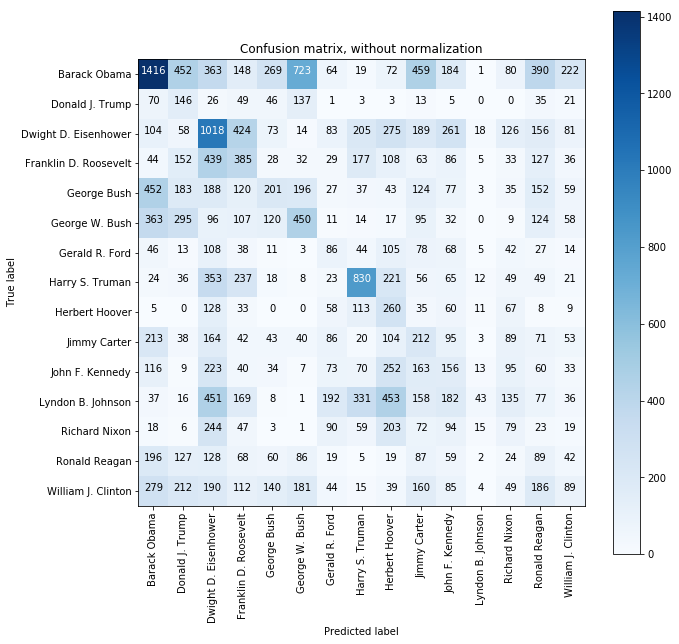

In [68]:
# Plot confusion matrix
#   from scikit-learn examples @
#   http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

plt.show()

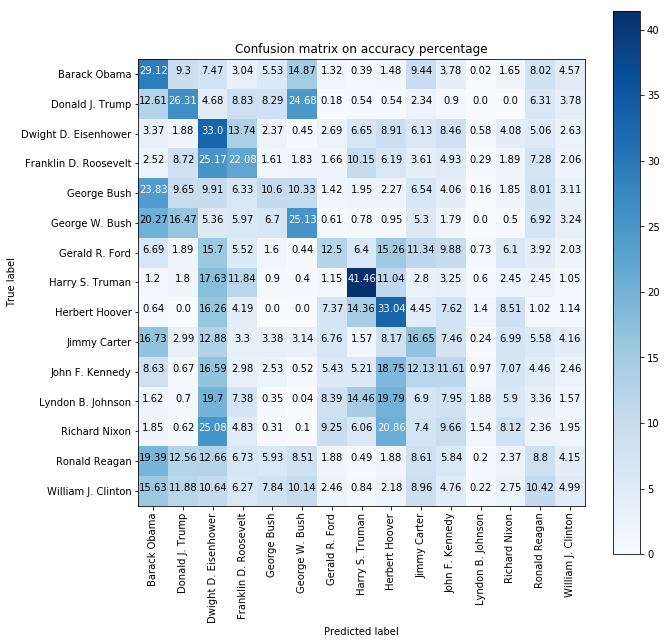

In [69]:
#Plot normalized confusion matrix
cnf_matrix_pct = cnf_matrix *1.0
cnf_matrix_pct = np.around(np.array([row*100.0/sum(row) for row in cnf_matrix_pct]), 2)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix_pct, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix on accuracy percentage')
plt.show()

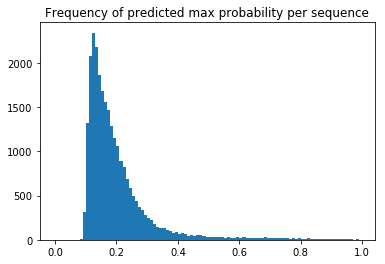

In [70]:
binwidth = .05
pred_outs = pred_y
plt.hist(pred_outs.max(axis=1),bins=np.arange(0.0, 1.0, 0.01))
plt.title('Frequency of predicted max probability per sequence')
plt.show()

In [ ]:
##
## MODEL OPTIMIZATION
##
from keras.layers import Input, Dense, SimpleRNN, Bidirectional, Dropout
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adamax
from keras.models import Model
from keras.utils import plot_model

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# define operating vars
#optimizer='rmsprop'
#dropout = 0.5422412690636627
#activation = "relu"
#batch_size = 50
#units = 50
#shuffle = True
#epochs = 150
#merge_mode = 'ave'

def create_model(optimizer='rmsprop', learn_rate=0.01,
                 init_mode1='glorot_uniform', init_mode2='glorot_uniform', 
                 merge_mode='ave', activation='relu', 
                 dropout_rate=0.0, neuron_count=50):
    # assemble & compile model
    main_input = Input(shape=(max_seq_len,unique_chars,))
    rnn = Bidirectional(SimpleRNN(units=neuron_count,
                                  activation=activation,
                                  kernel_initializer=init_mode1,
                                  recurrent_dropout=dropout_rate),
                        merge_mode=merge_mode)(main_input)
    main_output = Dense(len(labels),
                        activation='softmax',
                        kernel_initializer=init_mode2)(rnn)
    model = Model(inputs=[main_input], outputs=[main_output])
    model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy','categorical_accuracy'])

    return model


# instantiate model
model = KerasClassifier(build_fn=create_model, verbose=1)

# define the grid search parameters
epoch = [2]
batch_sizes = [unique_chars]
optimizers = ['Adamax']
init_modes1 = ['normal']
init_modes2 = init_modes1
merge_modes = ['concat']
activations = ['relu']
dropout_rates = [0.2]
neuron_counts = [unique_chars]
learn_rates = [0.2]
param_grid = dict(batch_size=batch_sizes,
                  epochs=epoch,
                  optimizer=optimizers,
                  learn_rate=learn_rates,
                  init_mode1=init_modes1,
                  init_mode2=init_modes2,
                  merge_mode=merge_modes,
                  activation=activations,
                  dropout_rate=dropout_rates,
                  neuron_count=neuron_counts)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=2, cv=2)
grid_result = grid.fit(train_X, train_y)

# summarize results
# from http://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))